In [1]:
pip install yfinance pycoingecko pandas numpy scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 6.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 8.5 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp311-cp311-macosx_11_0_arm64.whl size=267552 sha256=b155d8fc6191793c64e6f7dfc99453f7454f488f513d6c6c963e6940043e6a5d
  Stored in directory: /Users/bentodd/Library/Caches/pip/wheels/ff/6c/15/506e25bc390de450a7fa53c155cd9b0fbd13ad3e84a9abc183
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
from pycoingecko import CoinGeckoAPI
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def fetch_data(start_date='2020-01-01'):
    # Fetch NASDAQ data
    nasdaq = yf.download('^IXIC', start=start_date)
    nasdaq = nasdaq[['Close']].rename(columns={'Close': 'nasdaq_price'})
    
    # Fetch Bitcoin data
    cg = CoinGeckoAPI()
    bitcoin_data = cg.get_coin_market_chart_by_id('bitcoin', 'usd', days='max')
    
    # Convert Bitcoin data to DataFrame
    bitcoin_prices = pd.DataFrame(bitcoin_data['prices'], columns=['timestamp', 'bitcoin_price'])
    bitcoin_prices['date'] = pd.to_datetime(bitcoin_prices['timestamp'], unit='ms')
    bitcoin_prices.set_index('date', inplace=True)
    bitcoin_prices.drop('timestamp', axis=1, inplace=True)
    
    # Resample to daily data and align dates
    bitcoin_prices = bitcoin_prices.resample('D').last()
    
    # Merge datasets
    df = pd.merge(nasdaq, bitcoin_prices, left_index=True, right_index=True, how='inner')
    
    # Calculate daily returns
    df['nasdaq_return'] = df['nasdaq_price'].pct_change()
    df['bitcoin_return'] = df['bitcoin_price'].pct_change()
    
    return df.dropna()

def analyze_relationship(df):
    # Create lagged features
    for i in range(1, 6):
        df[f'nasdaq_lag_{i}'] = df['nasdaq_return'].shift(i)
        df[f'bitcoin_lag_{i}'] = df['bitcoin_return'].shift(i)
    
    df = df.dropna()
    
    # Prepare features for predicting Bitcoin
    X_bitcoin = df[[col for col in df.columns if 'nasdaq_lag' in col]]
    y_bitcoin = df['bitcoin_return']
    
    # Prepare features for predicting NASDAQ
    X_nasdaq = df[[col for col in df.columns if 'bitcoin_lag' in col]]
    y_nasdaq = df['nasdaq_return']
    
    # Split data
    X_bitcoin_train, X_bitcoin_test, y_bitcoin_train, y_bitcoin_test = train_test_split(
        X_bitcoin, y_bitcoin, test_size=0.2, random_state=42)
    X_nasdaq_train, X_nasdaq_test, y_nasdaq_train, y_nasdaq_test = train_test_split(
        X_nasdaq, y_nasdaq, test_size=0.2, random_state=42)
    
    # Train models
    bitcoin_model = LinearRegression().fit(X_bitcoin_train, y_bitcoin_train)
    nasdaq_model = LinearRegression().fit(X_nasdaq_train, y_nasdaq_train)
    
    # Calculate scores
    bitcoin_score = bitcoin_model.score(X_bitcoin_test, y_bitcoin_test)
    nasdaq_score = nasdaq_model.score(X_nasdaq_test, y_nasdaq_test)
    
    results = {
        'bitcoin_r2': bitcoin_score,
        'nasdaq_r2': nasdaq_score,
        'bitcoin_model': bitcoin_model,
        'nasdaq_model': nasdaq_model
    }
    
    return results

def plot_relationships(df):
    plt.figure(figsize=(12, 6))
    
    # Plot correlation
    plt.subplot(1, 2, 1)
    plt.scatter(df['nasdaq_return'], df['bitcoin_return'], alpha=0.5)
    plt.xlabel('NASDAQ Returns')
    plt.ylabel('Bitcoin Returns')
    plt.title('Daily Returns Correlation')
    
    # Plot prices (normalized)
    plt.subplot(1, 2, 2)
    normalized_prices = df[['nasdaq_price', 'bitcoin_price']].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()))
    normalized_prices.plot()
    plt.title('Normalized Prices')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Fetch and prepare data
    df = fetch_data()
    
    # Analyze relationships
    results = analyze_relationship(df)
    
    print(f"R² score for predicting Bitcoin from NASDAQ: {results['bitcoin_r2']:.4f}")
    print(f"R² score for predicting NASDAQ from Bitcoin: {results['nasdaq_r2']:.4f}")
    
    # Plot relationships
    plot_relationships(df)

[*********************100%***********************]  1 of 1 completed


ValueError: {'error': {'status': {'timestamp': '2024-11-21T04:19:23.963+00:00', 'error_code': 10012, 'error_message': 'Your request exceeds the allowed time range. Public API users are limited to querying historical data within the past 365 days. Upgrade to a paid plan to enjoy full historical data access: https://www.coingecko.com/en/api/pricing. '}}}

In [3]:
pip install yfinance pandas numpy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def fetch_data(start_date='2020-01-01'):
    # Fetch both NASDAQ and Bitcoin data from Yahoo Finance
    nasdaq = yf.download('^IXIC', start=start_date)
    bitcoin = yf.download('BTC-USD', start=start_date)
    
    # Select closing prices
    nasdaq = nasdaq[['Close']].rename(columns={'Close': 'nasdaq_price'})
    bitcoin = bitcoin[['Close']].rename(columns={'Close': 'bitcoin_price'})
    
    # Merge datasets
    df = pd.merge(nasdaq, bitcoin, left_index=True, right_index=True, how='inner')
    
    # Calculate daily returns
    df['nasdaq_return'] = df['nasdaq_price'].pct_change()
    df['bitcoin_return'] = df['bitcoin_price'].pct_change()
    
    return df.dropna()

def analyze_relationship(df):
    # Create lagged features
    for i in range(1, 6):
        df[f'nasdaq_lag_{i}'] = df['nasdaq_return'].shift(i)
        df[f'bitcoin_lag_{i}'] = df['bitcoin_return'].shift(i)
    
    df = df.dropna()
    
    # Prepare features for predicting Bitcoin
    X_bitcoin = df[[col for col in df.columns if 'nasdaq_lag' in col]]
    y_bitcoin = df['bitcoin_return']
    
    # Prepare features for predicting NASDAQ
    X_nasdaq = df[[col for col in df.columns if 'bitcoin_lag' in col]]
    y_nasdaq = df['nasdaq_return']
    
    # Split data
    X_bitcoin_train, X_bitcoin_test, y_bitcoin_train, y_bitcoin_test = train_test_split(
        X_bitcoin, y_bitcoin, test_size=0.2, random_state=42)
    X_nasdaq_train, X_nasdaq_test, y_nasdaq_train, y_nasdaq_test = train_test_split(
        X_nasdaq, y_nasdaq, test_size=0.2, random_state=42)
    
    # Train models
    bitcoin_model = LinearRegression().fit(X_bitcoin_train, y_bitcoin_train)
    nasdaq_model = LinearRegression().fit(X_nasdaq_train, y_nasdaq_train)
    
    # Calculate scores
    bitcoin_score = bitcoin_model.score(X_bitcoin_test, y_bitcoin_test)
    nasdaq_score = nasdaq_model.score(X_nasdaq_test, y_nasdaq_test)
    
    # Calculate feature importance
    bitcoin_importance = pd.DataFrame({
        'feature': X_bitcoin.columns,
        'importance': np.abs(bitcoin_model.coef_)
    }).sort_values('importance', ascending=False)
    
    nasdaq_importance = pd.DataFrame({
        'feature': X_nasdaq.columns,
        'importance': np.abs(nasdaq_model.coef_)
    }).sort_values('importance', ascending=False)
    
    results = {
        'bitcoin_r2': bitcoin_score,
        'nasdaq_r2': nasdaq_score,
        'bitcoin_model': bitcoin_model,
        'nasdaq_model': nasdaq_model,
        'bitcoin_importance': bitcoin_importance,
        'nasdaq_importance': nasdaq_importance
    }
    
    return results

def plot_relationships(df, results):
    # Create a figure with 2x2 subplots
    fig = plt.figure(figsize=(15, 12))
    
    # Plot 1: Correlation
    plt.subplot(2, 2, 1)
    plt.scatter(df['nasdaq_return'], df['bitcoin_return'], alpha=0.5)
    plt.xlabel('NASDAQ Returns')
    plt.ylabel('Bitcoin Returns')
    plt.title('Daily Returns Correlation')
    
    # Plot 2: Normalized Prices
    plt.subplot(2, 2, 2)
    normalized_prices = df[['nasdaq_price', 'bitcoin_price']].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()))
    normalized_prices.plot()
    plt.title('Normalized Prices')
    
    # Plot 3: NASDAQ Feature Importance
    plt.subplot(2, 2, 3)
    results['nasdaq_importance'].plot(kind='bar')
    plt.title('Feature Importance for Predicting NASDAQ')
    plt.xticks(rotation=45)
    
    # Plot 4: Bitcoin Feature Importance
    plt.subplot(2, 2, 4)
    results['bitcoin_importance'].plot(kind='bar')
    plt.title('Feature Importance for Predicting Bitcoin')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Fetch and prepare data
    df = fetch_data()
    
    # Analyze relationships
    results = analyze_relationship(df)
    
    print("\nPredictive Power Analysis:")
    print(f"R² score for predicting Bitcoin from NASDAQ: {results['bitcoin_r2']:.4f}")
    print(f"R² score for predicting NASDAQ from Bitcoin: {results['nasdaq_r2']:.4f}")
    
    print("\nMost important features for predicting Bitcoin:")
    print(results['bitcoin_importance'].head())
    
    print("\nMost important features for predicting NASDAQ:")
    print(results['nasdaq_importance'].head())
    
    # Plot relationships
    plot_relationships(df, results)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ValueError: at least one array or dtype is required

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def fetch_data(start_date='2020-01-01'):
    # Fetch both NASDAQ and Bitcoin data from Yahoo Finance
    nasdaq = yf.download('^IXIC', start=start_date)
    bitcoin = yf.download('BTC-USD', start=start_date)
    
    # Select closing prices
    nasdaq = nasdaq[['Close']].rename(columns={'Close': 'nasdaq_price'})
    bitcoin = bitcoin[['Close']].rename(columns={'Close': 'bitcoin_price'})
    
    # Merge datasets
    df = pd.merge(nasdaq, bitcoin, left_index=True, right_index=True, how='inner')
    
    # Calculate daily returns
    df['nasdaq_return'] = df['nasdaq_price'].pct_change()
    df['bitcoin_return'] = df['bitcoin_price'].pct_change()
    
    return df.dropna()

def analyze_relationship(df):
    # Create lagged features
    for i in range(1, 6):
        df[f'nasdaq_lag_{i}'] = df['nasdaq_return'].shift(i)
        df[f'bitcoin_lag_{i}'] = df['bitcoin_return'].shift(i)
    
    df = df.dropna()
    
    # Prepare features for predicting Bitcoin
    X_bitcoin = df[[col for col in df.columns if 'nasdaq_lag' in col]]
    y_bitcoin = df['bitcoin_return']
    
    # Prepare features for predicting NASDAQ
    X_nasdaq = df[[col for col in df.columns if 'bitcoin_lag' in col]]
    y_nasdaq = df['nasdaq_return']
    
    # Split data
    X_bitcoin_train, X_bitcoin_test, y_bitcoin_train, y_bitcoin_test = train_test_split(
        X_bitcoin, y_bitcoin, test_size=0.2, random_state=42)
    X_nasdaq_train, X_nasdaq_test, y_nasdaq_train, y_nasdaq_test = train_test_split(
        X_nasdaq, y_nasdaq, test_size=0.2, random_state=42)
    
    # Train models
    bitcoin_model = LinearRegression().fit(X_bitcoin_train, y_bitcoin_train)
    nasdaq_model = LinearRegression().fit(X_nasdaq_train, y_nasdaq_train)
    
    # Calculate scores
    bitcoin_score = bitcoin_model.score(X_bitcoin_test, y_bitcoin_test)
    nasdaq_score = nasdaq_model.score(X_nasdaq_test, y_nasdaq_test)
    
    results = {
        'bitcoin_r2': bitcoin_score,
        'nasdaq_r2': nasdaq_score,
        'bitcoin_features': list(X_bitcoin.columns),
        'nasdaq_features': list(X_nasdaq.columns),
        'bitcoin_coefficients': bitcoin_model.coef_,
        'nasdaq_coefficients': nasdaq_model.coef_
    }
    
    return results

def plot_relationships(df, results):
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Correlation
    plt.subplot(2, 2, 1)
    plt.scatter(df['nasdaq_return'], df['bitcoin_return'], alpha=0.5)
    plt.xlabel('NASDAQ Returns')
    plt.ylabel('Bitcoin Returns')
    plt.title('Daily Returns Correlation')
    
    # Plot 2: Normalized Prices
    plt.subplot(2, 2, 2)
    normalized_prices = df[['nasdaq_price', 'bitcoin_price']].apply(
        lambda x: (x - x.min()) / (x.max() - x.min()))
    normalized_prices.plot()
    plt.title('Normalized Prices')
    
    # Plot 3: NASDAQ Feature Importance
    plt.subplot(2, 2, 3)
    plt.bar(range(len(results['nasdaq_coefficients'])), 
            np.abs(results['nasdaq_coefficients']))
    plt.xticks(range(len(results['nasdaq_coefficients'])), 
               results['nasdaq_features'], 
               rotation=45)
    plt.title('Feature Importance for Predicting NASDAQ')
    
    # Plot 4: Bitcoin Feature Importance
    plt.subplot(2, 2, 4)
    plt.bar(range(len(results['bitcoin_coefficients'])), 
            np.abs(results['bitcoin_coefficients']))
    plt.xticks(range(len(results['bitcoin_coefficients'])), 
               results['bitcoin_features'], 
               rotation=45)
    plt.title('Feature Importance for Predicting Bitcoin')
    
    plt.tight_layout()
    plt.show()

def calculate_correlations(df):
    # Calculate rolling correlations
    window_sizes = [5, 30, 90]
    for window in window_sizes:
        col_name = f'correlation_{window}d'
        df[col_name] = df['nasdaq_return'].rolling(window).corr(df['bitcoin_return'])
    return df

if __name__ == "__main__":
    # Fetch and prepare data
    df = fetch_data()
    
    # Calculate correlations
    df = calculate_correlations(df)
    
    # Analyze relationships
    results = analyze_relationship(df)
    
    print("\nPredictive Power Analysis:")
    print(f"R² score for predicting Bitcoin from NASDAQ: {results['bitcoin_r2']:.4f}")
    print(f"R² score for predicting NASDAQ from Bitcoin: {results['nasdaq_r2']:.4f}")
    
    print("\nCorrelation Analysis:")
    for window in [5, 30, 90]:
        corr = df[f'correlation_{window}d'].mean()
        print(f"{window}-day rolling correlation (mean): {corr:.4f}")
    
    # Plot relationships
    plot_relationships(df, results)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


ValueError: at least one array or dtype is required

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed



NASDAQ data shape: (1231, 6)
Bitcoin data shape: (1786, 6)

Merged data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1230 entries, 2020-01-02 to 2024-11-19
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   (nasdaq_price, ^IXIC)     1230 non-null   float64
 1   (bitcoin_price, BTC-USD)  1230 non-null   float64
dtypes: float64(2)
memory usage: 28.8 KB
None

First few rows:
Price      nasdaq_price bitcoin_price
Ticker            ^IXIC       BTC-USD
Date                                 
2020-01-02  9092.190430   6985.470215
2020-01-03  9020.769531   7344.884277
2020-01-06  9071.469727   7769.219238
2020-01-07  9068.580078   8163.692383
2020-01-08  9129.240234   8079.862793

Returns statistics:
Price  nasdaq_return bitcoin_return
Ticker                             
count    1229.000000    1229.000000
mean        0.000730       0.002962
std         0.016148       0.041056
min      

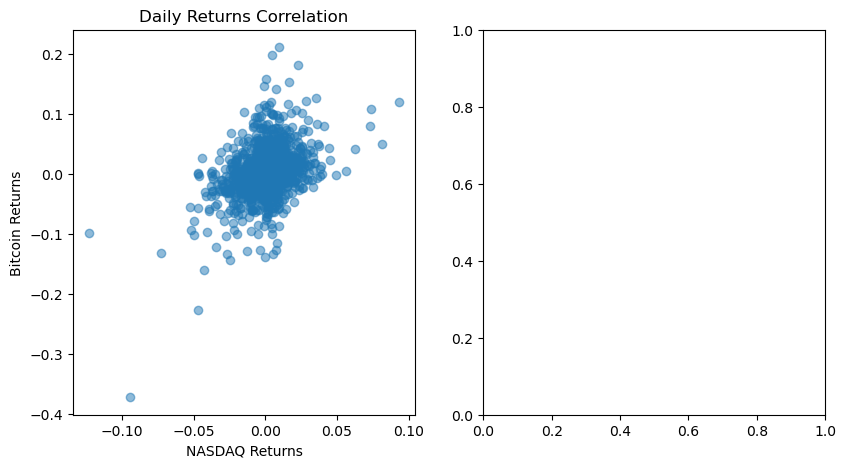

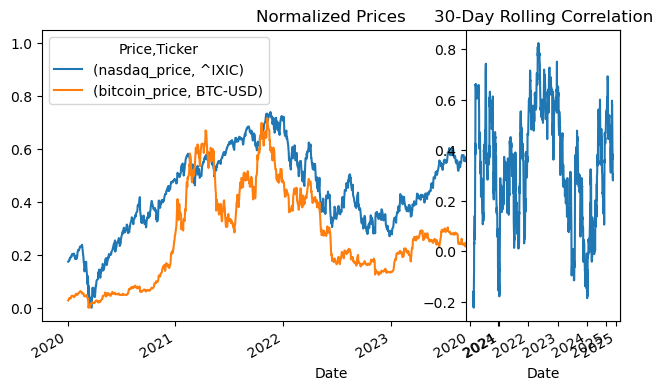


Analysis complete!


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Download data
start_date = '2020-01-01'
print("Downloading data...")

nasdaq = yf.download('^IXIC', start=start_date)
bitcoin = yf.download('BTC-USD', start=start_date)

# Verify data download
print("\nNASDAQ data shape:", nasdaq.shape)
print("Bitcoin data shape:", bitcoin.shape)

if nasdaq.empty or bitcoin.empty:
    raise ValueError("Failed to download data")

# Prepare initial dataframe
nasdaq_df = nasdaq[['Close']].rename(columns={'Close': 'nasdaq_price'})
bitcoin_df = bitcoin[['Close']].rename(columns={'Close': 'bitcoin_price'})

# Merge datasets
df = pd.merge(nasdaq_df, bitcoin_df, left_index=True, right_index=True, how='inner')
print("\nMerged data info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Check for and remove any infinite values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# Calculate returns
df['nasdaq_return'] = df['nasdaq_price'].pct_change()
df['bitcoin_return'] = df['bitcoin_price'].pct_change()
df = df.dropna()

print("\nReturns statistics:")
print(df[['nasdaq_return', 'bitcoin_return']].describe())

# Basic correlation analysis
correlation = df['nasdaq_return'].corr(df['bitcoin_return'])
print(f"\nOverall correlation between returns: {correlation:.4f}")

# Calculate rolling correlations
print("\nRolling correlations:")
for window in [5, 30, 90]:
    rolling_corr = df['nasdaq_return'].rolling(window).corr(df['bitcoin_return'])
    print(f"{window}-day correlation (mean): {rolling_corr.mean():.4f}")

# Plot the relationships
plt.figure(figsize=(15, 5))

# Plot returns
plt.subplot(1, 3, 1)
plt.scatter(df['nasdaq_return'], df['bitcoin_return'], alpha=0.5)
plt.xlabel('NASDAQ Returns')
plt.ylabel('Bitcoin Returns')
plt.title('Daily Returns Correlation')

# Plot prices
plt.subplot(1, 3, 2)
normalized_prices = df[['nasdaq_price', 'bitcoin_price']].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()))
normalized_prices.plot()
plt.title('Normalized Prices')

# Plot rolling correlation
plt.subplot(1, 3, 3)
df['30d_correlation'] = df['nasdaq_return'].rolling(30).corr(df['bitcoin_return'])
df['30d_correlation'].plot()
plt.title('30-Day Rolling Correlation')

plt.tight_layout()
plt.show()

print("\nAnalysis complete!")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


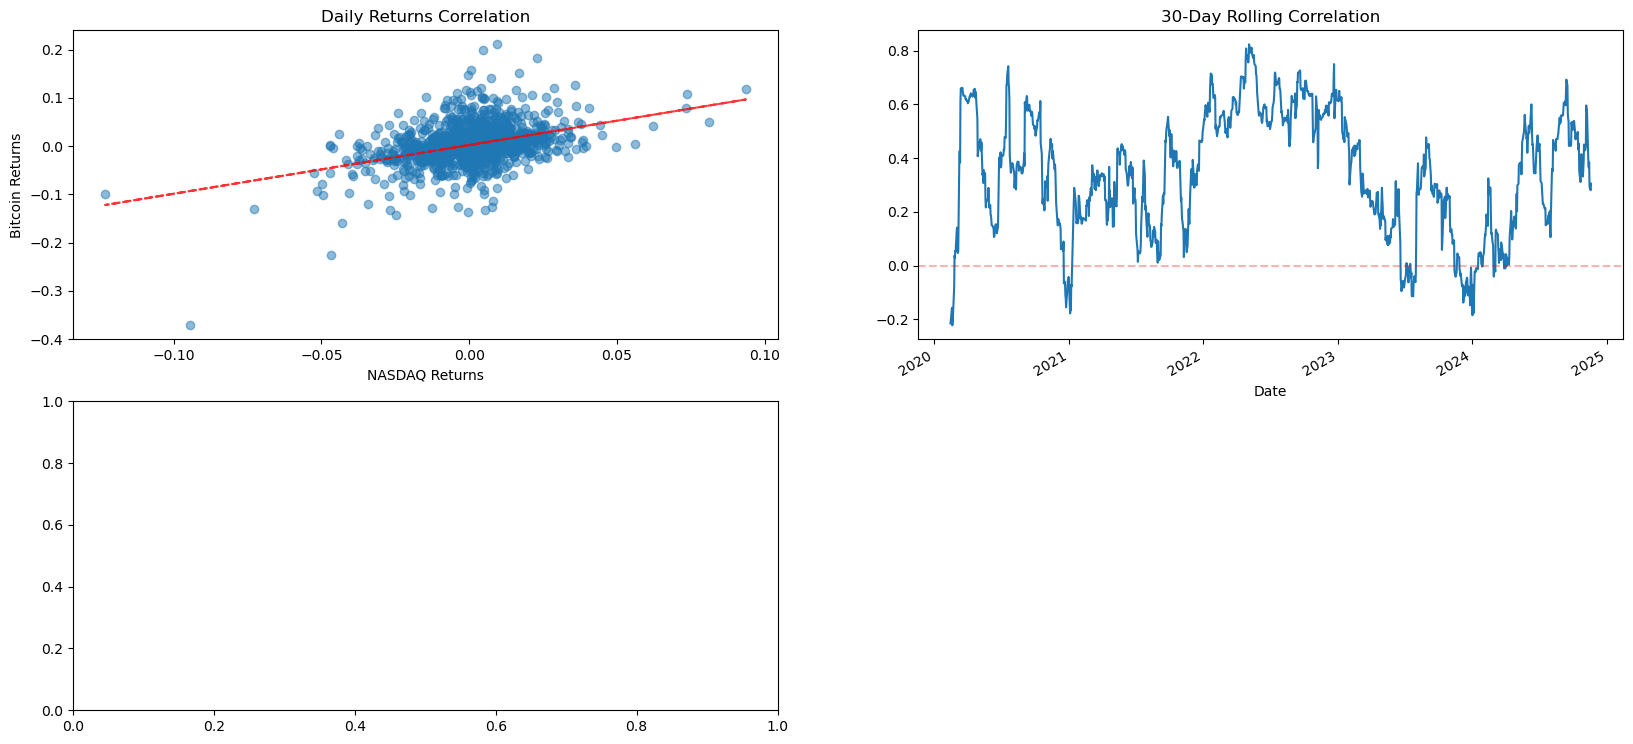

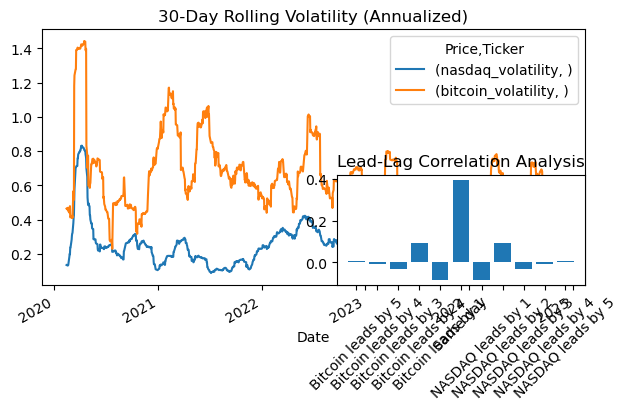


Detailed Statistics:

1. Basic Correlation Analysis:
Overall correlation: 0.3972

2. Lead-Lag Analysis:
Bitcoin leads by 5: 0.0040
Bitcoin leads by 4: -0.0072
Bitcoin leads by 3: -0.0306
Bitcoin leads by 2: 0.0936
Bitcoin leads by 1: -0.0839
Same day: 0.3972
NASDAQ leads by 1: -0.0839
NASDAQ leads by 2: 0.0936
NASDAQ leads by 3: -0.0306
NASDAQ leads by 4: -0.0072
NASDAQ leads by 5: 0.0040

3. Volatility Comparison:
NASDAQ average volatility: 0.23
Bitcoin average volatility: 0.61

4. High Correlation Periods:
Number of high correlation periods: 221
Example high correlation periods:
Price      nasdaq_price bitcoin_price nasdaq_return bitcoin_return  \
Ticker            ^IXIC       BTC-USD                                
Date                                                                 
2020-03-12  7201.799805   4970.788086     -0.094347      -0.371695   
2020-03-13  7874.879883   5563.707031      0.093460       0.119281   
2020-03-16  6904.589844   5014.479980     -0.123213      -0.0

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Download data
start_date = '2020-01-01'
print("Downloading data...")

nasdaq = yf.download('^IXIC', start=start_date)
bitcoin = yf.download('BTC-USD', start=start_date)

# Prepare dataframe
nasdaq_df = nasdaq[['Close']].rename(columns={'Close': 'nasdaq_price'})
bitcoin_df = bitcoin[['Close']].rename(columns={'Close': 'bitcoin_price'})
df = pd.merge(nasdaq_df, bitcoin_df, left_index=True, right_index=True, how='inner')

# Calculate returns
df['nasdaq_return'] = df['nasdaq_price'].pct_change()
df['bitcoin_return'] = df['bitcoin_price'].pct_change()
df = df.dropna()

# Calculate volatility
df['nasdaq_volatility'] = df['nasdaq_return'].rolling(30).std() * np.sqrt(252)  # Annualized
df['bitcoin_volatility'] = df['bitcoin_return'].rolling(30).std() * np.sqrt(252)

# Calculate whether each asset led or lagged the other
max_lag = 5
correlations = []
for lag in range(-max_lag, max_lag + 1):
    if lag < 0:
        corr = df['nasdaq_return'].corr(df['bitcoin_return'].shift(-lag))
        correlations.append(('Bitcoin leads by ' + str(-lag), corr))
    elif lag > 0:
        corr = df['nasdaq_return'].corr(df['bitcoin_return'].shift(lag))
        correlations.append(('NASDAQ leads by ' + str(lag), corr))
    else:
        corr = df['nasdaq_return'].corr(df['bitcoin_return'])
        correlations.append(('Same day', corr))

# Create subplots
fig = plt.figure(figsize=(20, 10))

# Plot 1: Returns scatter
plt.subplot(2, 2, 1)
plt.scatter(df['nasdaq_return'], df['bitcoin_return'], alpha=0.5)
plt.xlabel('NASDAQ Returns')
plt.ylabel('Bitcoin Returns')
z = np.polyfit(df['nasdaq_return'], df['bitcoin_return'], 1)
p = np.poly1d(z)
plt.plot(df['nasdaq_return'], p(df['nasdaq_return']), "r--", alpha=0.8)
plt.title('Daily Returns Correlation')

# Plot 2: Rolling correlation
plt.subplot(2, 2, 2)
df['30d_correlation'] = df['nasdaq_return'].rolling(30).corr(df['bitcoin_return'])
df['30d_correlation'].plot()
plt.title('30-Day Rolling Correlation')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)

# Plot 3: Volatility comparison
plt.subplot(2, 2, 3)
df[['nasdaq_volatility', 'bitcoin_volatility']].plot()
plt.title('30-Day Rolling Volatility (Annualized)')

# Plot 4: Lead-Lag Correlation
plt.subplot(2, 2, 4)
lags, corrs = zip(*correlations)
plt.bar(lags, corrs)
plt.xticks(rotation=45)
plt.title('Lead-Lag Correlation Analysis')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Statistics:")
print("\n1. Basic Correlation Analysis:")
print(f"Overall correlation: {df['nasdaq_return'].corr(df['bitcoin_return']):.4f}")

print("\n2. Lead-Lag Analysis:")
for lag, corr in correlations:
    print(f"{lag}: {corr:.4f}")

print("\n3. Volatility Comparison:")
print(f"NASDAQ average volatility: {df['nasdaq_volatility'].mean():.2f}")
print(f"Bitcoin average volatility: {df['bitcoin_volatility'].mean():.2f}")

print("\n4. High Correlation Periods:")
high_corr_periods = df[df['30d_correlation'] > df['30d_correlation'].mean() + df['30d_correlation'].std()]
print(f"Number of high correlation periods: {len(high_corr_periods)}")
if len(high_corr_periods) > 0:
    print("Example high correlation periods:")
    print(high_corr_periods.head())

print("\n5. Beta Analysis:")
slope, intercept, r_value, p_value, std_err = stats.linregress(df['nasdaq_return'], df['bitcoin_return'])
print(f"Beta (sensitivity of Bitcoin to NASDAQ): {slope:.4f}")
print(f"R-squared: {r_value**2:.4f}")
print(f"P-value: {p_value:.4f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



NASDAQ After NASDAQ Extreme Up:
Number of occurrences: 26
Mean return: -1.15% (vs normal: 0.09%)
Success rate: 30.8%
Standard deviation: 2.97%
Returns normally distributed: False

Statistical Significance:
P-value (vs zero): 0.0595
P-value (vs normal days): 0.0001
P-value (success rate vs 50%): 0.0336
Effect size (Cohen's d): -0.527
Minimum sample needed: 210

Interpretation:
- Returns are significantly different from normal days
- Success rate is significantly different from 50%
- Medium effect size

NASDAQ After NASDAQ Extreme Down:
Number of occurrences: 35
Mean return: 0.51% (vs normal: 0.09%)
Success rate: 54.3%
Standard deviation: 3.07%
Returns normally distributed: False

Statistical Significance:
P-value (vs zero): 0.3297
P-value (vs normal days): 0.1116
P-value (success rate vs 50%): 0.6108
Effect size (Cohen's d): 0.176
Minimum sample needed: 1124

Interpretation:

Bitcoin After Bitcoin Extreme Up:
Number of occurrences: 40
Mean return: 0.09% (vs normal: 0.26%)
Success rate:

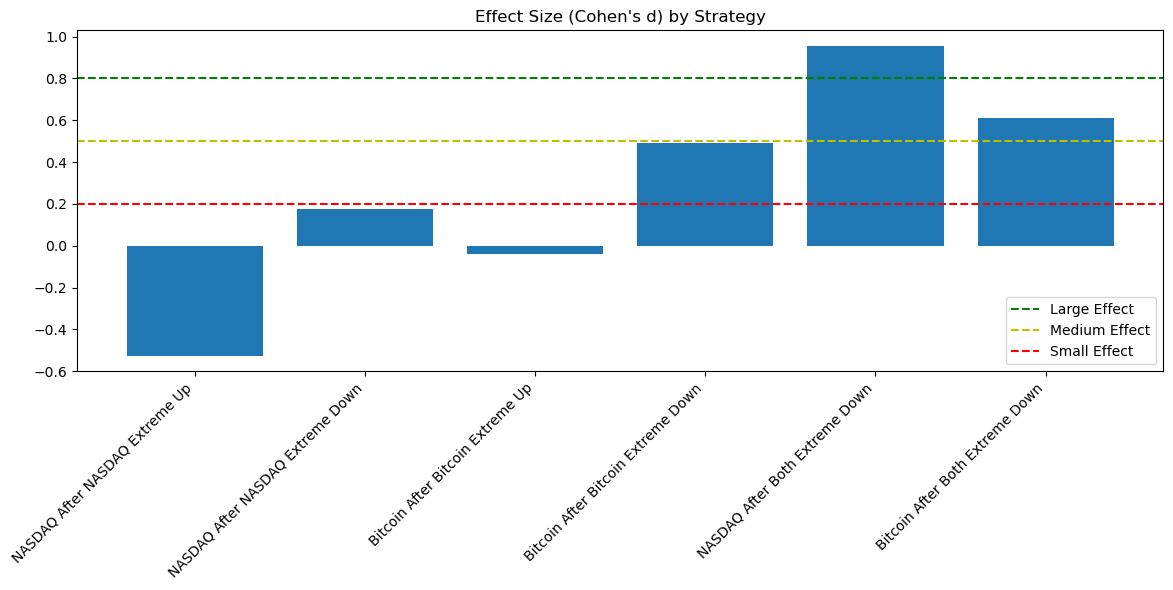

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, normaltest

def get_data():
    # Download data
    start_date = '2020-01-01'
    nasdaq = yf.download('^IXIC', start=start_date)
    bitcoin = yf.download('BTC-USD', start=start_date)
    
    # Prepare dataframe
    nasdaq_df = nasdaq[['Close']].rename(columns={'Close': 'nasdaq_price'})
    bitcoin_df = bitcoin[['Close']].rename(columns={'Close': 'bitcoin_price'})
    df = pd.merge(nasdaq_df, bitcoin_df, left_index=True, right_index=True, how='inner')
    
    # Calculate returns
    df['nasdaq_return'] = df['nasdaq_price'].pct_change()
    df['bitcoin_return'] = df['bitcoin_price'].pct_change()
    
    # Define extreme movements
    nasdaq_std = df['nasdaq_return'].std()
    bitcoin_std = df['bitcoin_return'].std()
    
    df['nasdaq_extreme_up'] = df['nasdaq_return'] > 2 * nasdaq_std
    df['nasdaq_extreme_down'] = df['nasdaq_return'] < -2 * nasdaq_std
    df['bitcoin_extreme_up'] = df['bitcoin_return'] > 2 * bitcoin_std
    df['bitcoin_extreme_down'] = df['bitcoin_return'] < -2 * bitcoin_std
    
    # Calculate next day returns
    df['next_day_nasdaq'] = df['nasdaq_return'].shift(-1)
    df['next_day_bitcoin'] = df['bitcoin_return'].shift(-1)
    
    return df

def analyze_significance(df, condition, asset_return, name):
    # Get returns after condition
    returns_after = df[condition][asset_return].dropna()
    
    # Get normal day returns (no extreme movements)
    normal_returns = df[~(df['nasdaq_extreme_up'] | df['nasdaq_extreme_down'] | 
                         df['bitcoin_extreme_up'] | df['bitcoin_extreme_down'])][asset_return].dropna()
    
    # Basic statistics
    mean_return = returns_after.mean() * 100
    std_return = returns_after.std() * 100
    count = len(returns_after)
    success_rate = (returns_after > 0).mean() * 100
    
    # Test for normality
    _, norm_p_value = normaltest(returns_after)
    
    # T-test against 0
    t_stat, t_p_value = ttest_1samp(returns_after, 0)
    
    # Compare success rate to random chance (50%)
    successes = (returns_after > 0).sum()
    n_trials = len(returns_after)
    z_stat, p_value = proportions_ztest(successes, n_trials, 0.5)
    
    # Compare to normal days
    normal_mean = normal_returns.mean() * 100
    t_stat_norm, p_value_norm = stats.ttest_ind(returns_after, normal_returns)
    
    # Effect size (Cohen's d)
    pooled_std = np.sqrt((returns_after.var() + normal_returns.var()) / 2)
    cohens_d = (returns_after.mean() - normal_returns.mean()) / pooled_std
    
    # Calculate minimum sample size needed for statistical significance
    effect_size = abs(mean_return) / std_return
    if effect_size > 0:
        min_sample = int(np.ceil((4 * (1.96 + 0.842)**2) / effect_size**2))
    else:
        min_sample = float('inf')
    
    results = {
        'name': name,
        'count': count,
        'mean_return': mean_return,
        'std_return': std_return,
        'success_rate': success_rate,
        'normal_mean': normal_mean,
        'p_value_vs_zero': t_p_value,
        'p_value_vs_normal': p_value_norm,
        'p_value_success_rate': p_value,
        'cohens_d': cohens_d,
        'min_sample_needed': min_sample,
        'is_normal': norm_p_value > 0.05
    }
    
    return results

# Get data and analyze
df = get_data()

# Define scenarios to test
scenarios = [
    (df['nasdaq_extreme_up'], 'next_day_nasdaq', "NASDAQ After NASDAQ Extreme Up"),
    (df['nasdaq_extreme_down'], 'next_day_nasdaq', "NASDAQ After NASDAQ Extreme Down"),
    (df['bitcoin_extreme_up'], 'next_day_bitcoin', "Bitcoin After Bitcoin Extreme Up"),
    (df['bitcoin_extreme_down'], 'next_day_bitcoin', "Bitcoin After Bitcoin Extreme Down"),
    (df['nasdaq_extreme_down'] & df['bitcoin_extreme_down'], 'next_day_nasdaq', "NASDAQ After Both Extreme Down"),
    (df['nasdaq_extreme_down'] & df['bitcoin_extreme_down'], 'next_day_bitcoin', "Bitcoin After Both Extreme Down")
]

results = [analyze_significance(df, condition, asset, name) for condition, asset, name in scenarios]

# Print results
for result in results:
    print(f"\n{result['name']}:")
    print(f"Number of occurrences: {result['count']}")
    print(f"Mean return: {result['mean_return']:.2f}% (vs normal: {result['normal_mean']:.2f}%)")
    print(f"Success rate: {result['success_rate']:.1f}%")
    print(f"Standard deviation: {result['std_return']:.2f}%")
    print(f"Returns normally distributed: {result['is_normal']}")
    print("\nStatistical Significance:")
    print(f"P-value (vs zero): {result['p_value_vs_zero']:.4f}")
    print(f"P-value (vs normal days): {result['p_value_vs_normal']:.4f}")
    print(f"P-value (success rate vs 50%): {result['p_value_success_rate']:.4f}")
    print(f"Effect size (Cohen's d): {result['cohens_d']:.3f}")
    print(f"Minimum sample needed: {result['min_sample_needed']}")
    
    print("\nInterpretation:")
    if result['p_value_vs_zero'] < 0.05:
        print("- Returns are significantly different from zero")
    if result['p_value_vs_normal'] < 0.05:
        print("- Returns are significantly different from normal days")
    if result['p_value_success_rate'] < 0.05:
        print("- Success rate is significantly different from 50%")
    if abs(result['cohens_d']) > 0.8:
        print("- Large effect size")
    elif abs(result['cohens_d']) > 0.5:
        print("- Medium effect size")
    elif abs(result['cohens_d']) > 0.2:
        print("- Small effect size")
    
    if result['count'] < result['min_sample_needed']:
        print(f"WARNING: More samples needed (have {result['count']}, need {result['min_sample_needed']})")

# Visualize effect sizes
plt.figure(figsize=(12, 6))
names = [r['name'] for r in results]
effect_sizes = [r['cohens_d'] for r in results]
plt.bar(names, effect_sizes)
plt.xticks(rotation=45, ha='right')
plt.title("Effect Size (Cohen's d) by Strategy")
plt.axhline(y=0.8, color='g', linestyle='--', label='Large Effect')
plt.axhline(y=0.5, color='y', linestyle='--', label='Medium Effect')
plt.axhline(y=0.2, color='r', linestyle='--', label='Small Effect')
plt.legend()
plt.tight_layout()
plt.show()